# Northwind Database Project

Name: Hazel Donaldson <br>
Due Date: 8/29/2019 <br>

# Project Overview:

In this project, we will be exploring data provided to us by our client, Northwind, containing sales data for a range of different products. Our goal is to provide the company with several business recommendations through statistically analysis and hypothesis testing.

## 1. Obtain Data/Import Libraries

In [1]:
#import libraries here
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from statsmodels.graphics.factorplots import interaction_plot
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.power import TTestIndPower, TTestPower
import warnings
warnings.filterwarnings('ignore')
import scipy as sp

In [2]:
#define functions

#Cohen's d for effect size
def cohen_d(group1, group2):
               
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)
#comparing average as discount boolean
def print_results(a,b):
    print(f"Average with discount: {round(a,2)}")
    print(f"Average without discount: {round(b, 2)}")
    print(f"Effect Size: {round((a-b), 2)}")
    print(f"Relative Effect Size: {round((a-b)/b, 2)}")
def results_printer_disc(a, b):
    print(f'Avg at current discount level: {round(a, 2)}')
    print(f'Effect Size: {round((a-b),2)}')
    print(f'Relative effect size: {round((a-b)/b,2)}')
    
# Calculate variance ratio for 2 samples:    
def variance_ratio(a,b):
    return np.var(a)/np.var(b)
def ttest_result(result, alpha):
    """after performing a t-test, use the p-value to tell us whether to reject or fail to reject the null hypothesis"""
    if (result[1] > 0.05):
               print(f"Fail to reject null hypothesis.\n Results are not statisitically significant with a p-value ={result[1]}")
    else:
               print(f"Reject the null hypothesis.\n Results are statistically significant with a p-value ={result[1]}")

### Connecting Database

In [3]:
#connect to database
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

In [ ]:
#create list of tables
c.execute("""SELECT name from sqlite_master WHERE type = 'table';""")
tables = c.fetchall()
tables = [i[0] for i in tables]

In [ ]:
dfs = []
for i in tables:
    table = c.execute('select * from "'+i+'"').fetchall()
    columns = c.execute('PRAGMA table_info ("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
    foo = i + "_df"
    exec(foo + "= df")
    dfs.append(foo)

## Add screenshot of schema

Below is an overview of the Northwind schema. Here I will do light exploration to familarize myself with the different tables that would of interest to us.


In [4]:
from IPython.display import Image
from IPython.display import HTML
Image(url = "https://raw.githubusercontent.com/learn-co-students/dsc-mod-3-project-online-ds-pt-041519/master/Northwind_ERD_updated.png")

## Question # 1

##  Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

This question needs to be split into two different hypothesis tests.
- For the first part, I will do a two-tailed t-test to compare discounts vs no discounts
- For the second part, I will do an ANOVA/Tukey test to compare all the discount levels

### Part 1:

$H_0$: Discounts have no effect on the number of products customers order <br>
$H_a$: Discounts can either increase or decrease the number of products customers order <br>
$alpha$ : 0.05

In [5]:
c.execute("""SELECT ProductId, UnitPrice, Quantity, Discount FROM OrderDetail""")
discounts = pd.DataFrame(c.fetchall())
discounts.columns = [column[0] for column in c.description]
discounts.head()

,ProductId,UnitPrice,Quantity,Discount
0,11,14.0,12,0.0
1,42,9.8,10,0.0
2,72,34.8,5,0.0
3,14,18.6,9,0.0
4,51,42.4,40,0.0


In [6]:
discounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 4 columns):
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(2)
memory usage: 67.4 KB


In [7]:
len(discounts.ProductId.unique())

77

We have 77 unique products from 2155 rows of data. Now I will create a new column representing a boolean presence of discounts.  Check what kind of discount levels are in the dataframe and then create a visualization for the difference in discount vs. no discount.

In [8]:
#looking for the presence of a discount
discounts['DiscBool'] = discounts['Discount'].apply(lambda x: 0 if x == 0 else 1)
discounts.head()

,ProductId,UnitPrice,Quantity,Discount,DiscBool
0,11,14.0,12,0.0,0
1,42,9.8,10,0.0,0
2,72,34.8,5,0.0,0
3,14,18.6,9,0.0,0
4,51,42.4,40,0.0,0


In [9]:
discounts.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

The value count of the different discount levels avaiable show us that a bulk of the discount levels are all divisible by 0.05 and the ones that aren't will be removed from the dataframe.

In [10]:
discounts = discounts[discounts.Discount.isin([0.00, 0.05, 0.10, 0.15, 0.20, 0.25])] 
discounts.head()

,ProductId,UnitPrice,Quantity,Discount,DiscBool
0,11,14.0,12,0.0,0
1,42,9.8,10,0.0,0
2,72,34.8,5,0.0,0
3,14,18.6,9,0.0,0
4,51,42.4,40,0.0,0


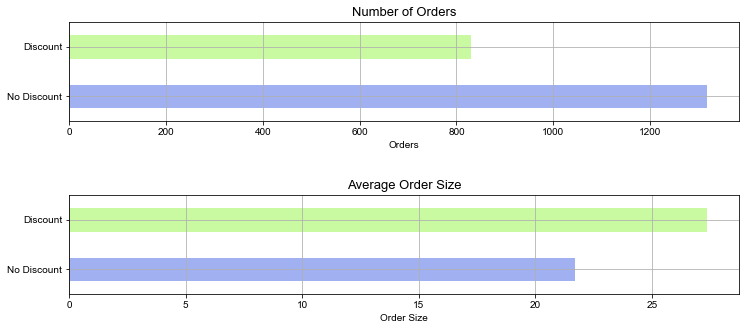

In [11]:
# Comparing the Number of Orders and Average Order Size to DisBool
fig, axes = plt.subplots(2, 1, figsize = (12, 5))
sns.set_style('whitegrid')

#Grouping DataFrame for visualization
discounts.groupby(['DiscBool'])['Quantity'].count().plot(kind = 'barh', ax = axes[0], color = ['#a0b0f0', '#c9f9a0'])
discounts.groupby(['DiscBool'])['Quantity'].mean().plot(kind = 'barh', ax = axes[1], color = ['#a0b0f0', '#c9f9a0'])
# First plot labels
axes[0].set_title('Number of Orders', fontsize = 13)
axes[0].set_xlabel('Orders')
axes[0].set_ylabel('')
axes[0].set_yticklabels(['No Discount', 'Discount'])
#Second plot labels
axes[1].set_title('Average Order Size', fontsize = 13)
axes[1].set_xlabel('Order Size')
axes[1].set_ylabel('')
axes[1].set_yticklabels(['No Discount', 'Discount'])
fig.subplots_adjust(hspace = .75)
fig.savefig('orders_numandsize.png', bbox_inches = 'tight')
plt.show()

In [12]:
print(f"There are {discounts.groupby(['DiscBool'])['Quantity'].count()[0]-discounts.groupby(['DiscBool'])['Quantity'].count()[1]} more orders made where there is no discount.")
print(f"The average order size for discounted items was {discounts.groupby(['DiscBool'])['Quantity'].mean()[1]-discounts.groupby(['DiscBool'])['Quantity'].mean()[0]} items greater than the order size when there was no discount")

There are 487 more orders made where there is no discount.
The average order size for discounted items was 5.638954908472158 items greater than the order size when there was no discount


As we can see non-discounted items account for the higher number of orders but discounted items have a larger average order size. We will investigate if this difference statisitcally significance.

In [13]:
# Separating dataframe between discounted and non-discounted order quantities:
control = discounts[discounts['Discount']== 0]['Quantity'] #non discounted products
experimental = discounts[discounts['Discount'] != 0]['Quantity'] #discounted products

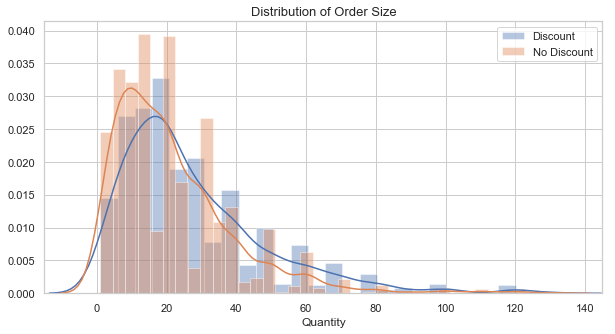

In [14]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.set_style('whitegrid')

ax = sns.distplot(experimental, label = 'Discount')
ax = sns.distplot(control, label = 'No Discount')
#ax = sns.kdeplot(gen_discount, label = 'Discount KDE')
#ax = sns.kdeplot(gen_nodiscount, label = 'No Discount KDE')
ax.set_xlim(-15, 145)
ax.set_title('Distribution of Order Size', fontsize = 13)
ax.legend()

In [15]:
#showing results from the print_result function
a = experimental.mean()
b = control.mean()
print_results(a,b)

Average with discount: 27.35
Average without discount: 21.72
Effect Size: 5.64
Relative Effect Size: 0.26


The KDE plot confirms what we observed above that there are more non discounted items sold but the discounted items account for the higher average order quantity size. The KDE plot is positively skewed but for the most part looks like a normal distribution, which means we can move forward with a t-test. In statistics, the Welch's test is a two sample location test that is used to test the hypothesis that the two populations have equal means. 

In [16]:
#Welch's t-test and cohen's d
result = stats.ttest_ind(experimental, control)
d = cohen_d(experimental, control)
ttest_result(result, 0.05)
print(d)

Reject the null hypothesis.
 Results are statistically significant with a p-value =1.7401995278127614e-11
0.2997078720940889


Because the p-value is less than 0.05, we can reject the null hypothesis and say that discounts do impact the number of quantity of orders made. The effect size or cohen's d value tells that this significance is a bit small to medium. Moving on to part 2...

### Part 2:

$H_0$ : The average number of orders is the same regardless of discount level <br>
$H_a$ : The average number of orders is not the same the level of discount changes <br>
$alpha$ : 0.05

In [17]:
discounts.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

In [18]:
query = 'DiscBool != 0' #removing the non-discounted orders
discounted = discounts.query(query)
discounted.head(3)

,ProductId,UnitPrice,Quantity,Discount,DiscBool
6,51,42.4,35,0.15,1
7,65,16.8,15,0.15,1
8,22,16.8,6,0.05,1


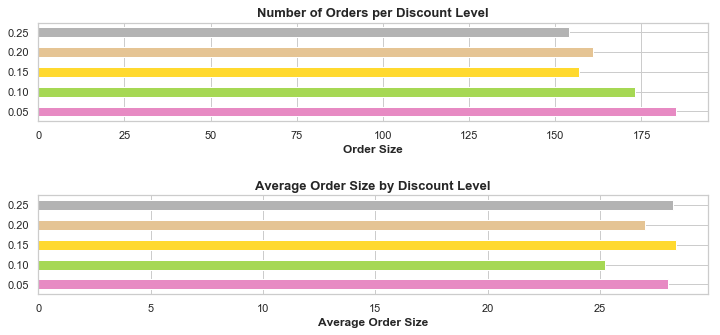

In [19]:
#Viewing difference between discount levels against number of orders and average order size visually
#fig, axes = plt.subplot(1, 2, figsize = (12,5))
fig, axes = plt.subplots(2, 1, figsize=(12,5))
sns.set_style('whitegrid')
#Grouping dataframe
discounted.groupby(['Discount'])['Quantity'].count().plot(kind = 'barh', ax = axes[0], color=['#E78AC3', '#A6D854', '#FFD92F', '#E5C494', '#B3B3B3', '#66C2A5'])
discounted.groupby(['Discount'])['Quantity'].mean().plot(kind = 'barh', ax = axes[1], color=['#E78AC3', '#A6D854', '#FFD92F', '#E5C494', '#B3B3B3', '#66C2A5'])
#Plot 1 labels
axes[0].set_title('Number of Orders per Discount Level', fontweight = 'bold', fontsize = 13)
axes[0].set_xlabel('Order Size', fontweight = 'semibold')
axes[0].set_ylabel('')
axes[0].set_yticklabels(['0.05', '0.10', '0.15', '0.20', '0.25'])

#Plot 2 labels
axes[1].set_title('Average Order Size by Discount Level', fontweight = 'bold', fontsize = 13)
axes[1].set_xlabel('Average Order Size', fontweight = 'semibold')
axes[1].set_ylabel('')
axes[1].set_yticklabels(['0.05', '0.10', '0.15', '0.20', '0.25'])
fig.subplots_adjust(hspace = .75);
fig.savefig('discountlevels.png', bbox_inches = 'tight')

In contrast to the bar graph above, we can see that the difference between the difference discount levels are much smaller for number of orders and average order size. We will investigate if this difference is significance.

In [20]:
#fitting using statsmodels ols
lm = ols('Quantity ~ C(Discount)', discounted).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6741
Date:                Thu, 29 Aug 2019   Prob (F-statistic):              0.610
Time:                        11:28:56   Log-Likelihood:                -3691.7
No. Observations:                 830   AIC:                             7393.
Df Residuals:                     825   BIC:                             7417.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              28.0108      1.525     18.372      0.000      25.018      31.003
C(Discount)[T.0.1]     -2.7738      2.193     -1.265      0.206      -7.079       1.531
C(Discount)[T.0.15]     0.3714      2.250      0.165      0.869      -4.045       4.788
C(Discount)[T.0.2]     -0.9860      2.235     -0.441      0.659      -5.373       3.401
C(Discount)[T.0.25]     0.2294      2.262      0.101      0.919      -4.211       4.669
==============================================================================
Omnibus:                      263.705   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              751.622
Skew:                           1.598   Prob(JB):                    6.13e-164
Kurtosis:                       6.394   Cond. No.                         5.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
#ANOVA analysis to test multiple comparisons test
sm.stats.anova_lm(lm, typ = 2)

,sum_sq,df,F,PR(>F)
C(Discount),1159.517551,4.0,0.674103,0.610041
Residual,354768.342690,825.0,NaN,NaN


We fail to reject the null hypothesis as the p-value is greater than 0.05. Turning each discount level into a dataframe for the Tukey test.

In [22]:
disc_bool_05 = discounted[discounted.Discount.isin([0.05])]
disc_bool_10 = discounted[discounted.Discount.isin([0.10])]
disc_bool_15 = discounted[discounted.Discount.isin([0.15])]
disc_bool_20 = discounted[discounted.Discount.isin([0.20])]
disc_bool_25 = discounted[discounted.Discount.isin([0.25])]
disc_bool_05.head() #sanity check

,ProductId,UnitPrice,Quantity,Discount,DiscBool
8,22,16.8,6,0.05,1
9,57,15.6,15,0.05,1
11,20,64.8,40,0.05,1
12,33,2.0,25,0.05,1
51,12,30.4,12,0.05,1


In [23]:
#Prepping for tukey test:
values = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25]
discounted_tukey = discounted[discounted.Discount.isin(values)]
discounted_tukey.head()

,ProductId,UnitPrice,Quantity,Discount,DiscBool
6,51,42.4,35,0.15,1
7,65,16.8,15,0.15,1
8,22,16.8,6,0.05,1
9,57,15.6,15,0.05,1
11,20,64.8,40,0.05,1


In [24]:
#Tukey test
tk = pairwise_tukeyhsd(discounted_tukey.Quantity, discounted_tukey.Discount, .05)
print(tk)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 0.05   0.1   -2.7738  -8.7696 3.222  False 
 0.05   0.15   0.3714  -5.7803 6.523  False 
 0.05   0.2    -0.986  -7.0962 5.1242 False 
 0.05   0.25   0.2294  -5.9546 6.4134 False 
 0.1    0.15   3.1452  -3.1037 9.394  False 
 0.1    0.2    1.7879  -4.4202 7.9959 False 
 0.1    0.25   3.0033  -3.2774 9.2839 False 
 0.15   0.2   -1.3573   -7.716 5.0014 False 
 0.15   0.25  -0.1419  -6.5715 6.2877 False 
 0.2    0.25   1.2154  -5.1745 7.6054 False 
--------------------------------------------


Reviewing the Tukey test, all comparisons fail to reject the null hypothesis. 
The results of our hypothesis test tells us that discounts do have a statistically significant effect on the order quantity. However the discount level doesn't have an impact.

# Question # 2

## Do discounts have a statistically significant effect on revenue? Is so, at what discount level(s) increase revenue?

- $H_0$: The average revenue is the same for orders with or without discounts <br>
- $H_a$: The average revenue is greater for orders with discounts <br>
- $alpha$ = 0.05 <br>

### Part 1:

In [25]:
c.execute("""SELECT od.OrderId, od.UnitPrice, od.Discount, od.Quantity,
                    SUM(od.Quantity * od.UnitPrice * (1-od.Discount)) OrderPrice
                    FROM OrderDetail od
                    INNER JOIN Product p on od.ProductId = p.Id
                    GROUP BY od.OrderId""")
disc_spend = pd.DataFrame(c.fetchall())
disc_spend.columns  =[column[0] for column in c.description]
print(len(disc_spend))
disc_spend.head()

830


,OrderId,UnitPrice,Discount,Quantity,OrderPrice
0,10248,14.0,0.00,12,440.00
1,10249,18.6,0.00,9,1863.40
2,10250,7.7,0.00,10,1552.60
3,10251,16.8,0.05,6,654.06
4,10252,64.8,0.05,40,3597.90


In [26]:
disc_spend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 5 columns):
OrderId       830 non-null int64
UnitPrice     830 non-null float64
Discount      830 non-null float64
Quantity      830 non-null int64
OrderPrice    830 non-null float64
dtypes: float64(3), int64(2)
memory usage: 32.5 KB


In [27]:
#identifying presence of discounts
disc_spend['DiscBool'] = disc_spend.Discount.apply(lambda x:0 if x == 0 else 1 )
disc_spend.head()

,OrderId,UnitPrice,Discount,Quantity,OrderPrice,DiscBool
0,10248,14.0,0.00,12,440.00,0
1,10249,18.6,0.00,9,1863.40,0
2,10250,7.7,0.00,10,1552.60,0
3,10251,16.8,0.05,6,654.06,1
4,10252,64.8,0.05,40,3597.90,1


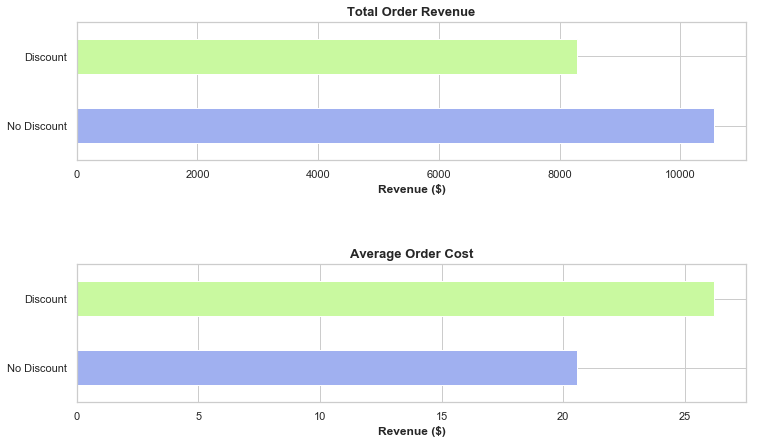

In [28]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(2, 1, figsize=(12,7))
disc_spend.groupby(['DiscBool'])['Quantity'].sum().plot(kind = 'barh', ax = axes[0], color = ['#a0b0f0', '#c9f9a0'])
disc_spend.groupby(['DiscBool'])['Quantity'].mean().plot(kind = 'barh', ax = axes[1],color = ['#a0b0f0', '#c9f9a0'] )
#plot 1:
# Subplot 1 Labels:
axes[0].set_title('Total Order Revenue', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Revenue ($)', fontweight='semibold')
axes[0].set_ylabel('')
axes[0].set_yticklabels(['No Discount', 'Discount'])

#Subplot 2 Labels:
axes[1].set_title('Average Order Cost', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Revenue ($)', fontweight='semibold')
axes[1].set_ylabel('')
axes[1].set_yticklabels(['No Discount', 'Discount'])
fig.subplots_adjust(hspace=.75)
fig.savefig('orderrev.png', bbox_inches = 'tight')

Based on the visualization above, we can see that Northwind earns more total revenue on non-discounted items but the average order cost is higher for discounted items. We will investigate further if these differences are statistically significant.

In [29]:
#separating the dataframe between discounted and non-discounted items:
discounted = disc_spend[disc_spend['Discount']!= 0]
not_discounted = disc_spend[disc_spend['Discount']== 0]
#sanity check
not_discounted.head()

,OrderId,UnitPrice,Discount,Quantity,OrderPrice,DiscBool
0,10248,14.0,0.0,12,440.0,0
1,10249,18.6,0.0,9,1863.4,0
2,10250,7.7,0.0,10,1552.6,0
5,10253,10.0,0.0,20,1444.8,0
7,10255,15.2,0.0,20,2490.5,0


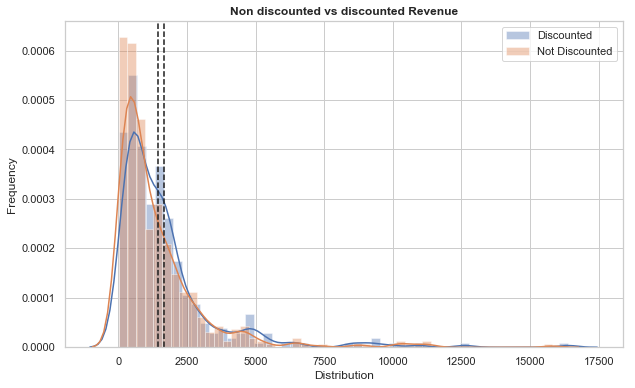

In [30]:
plt.figure(figsize=(10,6))
sns.distplot(discounted.OrderPrice, bins = 50, label = 'Discounted')
sns.distplot(not_discounted.OrderPrice, bins = 50, label = 'Not Discounted')

plt.axvline(discounted.OrderPrice.mean(), color = 'k', linestyle = '--')
plt.axvline(not_discounted.OrderPrice.mean(), color = 'k', linestyle = '--')

plt.title('Non discounted vs discounted Revenue', fontweight = 'bold')
plt.xlabel('Distribution')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Text(0.5, 0, 'Revenue -log transformed')

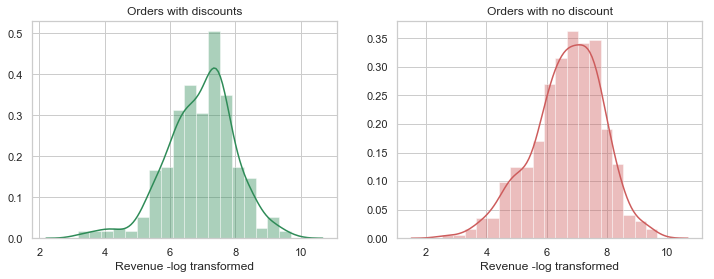

In [31]:
discounted_log = disc_spend.copy()
discounted_log['LogOrderPrice'] = np.log(disc_spend['OrderPrice'])
discount_log = discounted_log[discounted_log['DiscBool']== 1]
no_discount_log = discounted_log[discounted_log['DiscBool']== 0]
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
sns.distplot(discount_log.LogOrderPrice, color = 'seagreen', ax=ax1)
sns.distplot(no_discount_log.LogOrderPrice, color = 'indianred', ax= ax2)
ax1.set_title('Orders with discounts')
ax2.set_title('Orders with no discount')
ax1.set_xlabel('Revenue -log transformed')
ax2.set_xlabel('Revenue -log transformed')

In [32]:
result = stats.ttest_ind(discount_log.LogOrderPrice, no_discount_log.LogOrderPrice)
#d = cohen_d(discounted.OrderPrice, not_discounted.OrderPrice)
ttest_result(result, 0.05)
#print(d)

Reject the null hypothesis.
 Results are statistically significant with a p-value =0.0013692485593129766


In [33]:
a = discounted.OrderPrice.mean()
b = not_discounted.OrderPrice.mean()
print_results(a,b)

Average with discount: 1676.43
Average without discount: 1431.99
Effect Size: 244.44
Relative Effect Size: 0.17


Because the resulting p-value is less than 0.05, we  reject the null hypothesis that states that discounts have an effect on customer spending. 

### Part 2:

- $H_0$: The order price is the same regardless of discount level
- $H_a$ : The customer order price is not the same as the discount level changes
- $alpha$ = 0.05

In [34]:
#ANOVA:
lm = ols('OrderPrice ~ C(Discount)', discount_log).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             OrderPrice   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6774
Date:                Thu, 29 Aug 2019   Prob (F-statistic):              0.608
Time:                        11:29:28   Log-Likelihood:                -2840.4
No. Observations:                 316   AIC:                             5691.
Df Residuals:                     311   BIC:                             5710.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1872.4499    222.678      8.409      0.000    1434.304    2310.596
C(Discount)[T.0.1]   -421.1493    333.418     -1.263      0.207   -1077.190     234.891
C(Discount)[T.0.15]  -185.7763    346.830     -0.536      0.593    -868.206     496.653
C(Discount)[T.0.2]   -381.7965    327.773     -1.165      0.245   -1026.730     263.137
C(Discount)[T.0.25]   -10.5489    341.423     -0.031      0.975    -682.340     661.242
==============================================================================
Omnibus:                      257.135   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3886.484
Skew:                           3.358   Prob(JB):                         0.00
Kurtosis:                      18.813   Cond. No.                         5.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
sm.stats.anova_lm(lm, typ = 2)

,sum_sq,df,F,PR(>F)
C(Discount),1.034529e+07,4.0,0.677387,0.608083
Residual,1.187425e+09,311.0,NaN,NaN


The ANOVA table gives us a p-value of 0.6 which is greater than 0.05, so we fail to reject the null hypothesis

## Question 3

## Does the average amount spent per order vary between customers of different regions?

-$H_0$: The average order amount is the same across all customer regions <br>
-$H_a$: The averagr order amount is different between the different customer regions <br>
-$alpha$ =0.05 <br>

In [36]:
c.execute("""SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Quantity, od.Discount, 
(od.Quantity * od.UnitPrice * (1-od.Discount)) PriceperOrder FROM Customer c 
JOIN [Order] o on c.Id=o.CustomerId
JOIN OrderDetail od on od.OrderId=o.Id""")
customer_region = pd.DataFrame(c.fetchall())
customer_region.columns = [column[0] for column in c.description]
customer_region.head()

,Region,OrderId,Quantity,UnitPrice,Quantity,Discount,PriceperOrder
0,Western Europe,10248,12,14.0,12,0.0,168.0
1,Western Europe,10248,10,9.8,10,0.0,98.0
2,Western Europe,10248,5,34.8,5,0.0,174.0
3,Western Europe,10249,9,18.6,9,0.0,167.4
4,Western Europe,10249,40,42.4,40,0.0,1696.0


In [37]:
customer_region = customer_region.groupby(['Region', 'OrderId'])['PriceperOrder'].sum().reset_index()
customer_region.head()

,Region,OrderId,PriceperOrder
0,British Isles,10289,479.4
1,British Isles,10298,2645.0
2,British Isles,10309,1762.0
3,British Isles,10315,516.8
4,British Isles,10318,240.4


In [38]:
#customer_region.drop('OrderId', axis = 1, inplace = True)
customer_region.groupby('Region').count()

,OrderId,PriceperOrder
Region,,
British Isles,75,75
Central America,21,21
Eastern Europe,7,7
North America,152,152
Northern Europe,55,55
Scandinavia,28,28
South America,127,127
Southern Europe,64,64
Western Europe,272,272


Because I will be using ANOVA to test this hypothesis, we will ensure that the sample sizes are relatively the same size. Smaller groups will be put together that make geographical sense. 

In [39]:
#Combining E. & S. Europe:
customer_region.loc[(customer_region.Region == 'Eastern Europe') | (customer_region.Region == 'Southern Europe'), 'Region'] = "Southern and Eastern Europe"
#Combining Scandinavia & N.Europe:
customer_region.loc[(customer_region.Region == 'Scandinavia') | (customer_region.Region == 'Northern Europe'), 'Region'] = "Scandinavia and Eastern Europe"
#combining S & C. America:
customer_region.loc[(customer_region.Region == 'South America') | (customer_region.Region == 'Central America'), 'Region'] = "South and Central America"

In [40]:
customer_region.groupby('Region').count() #confirming sample size

,OrderId,PriceperOrder
Region,,
British Isles,75,75
North America,152,152
Scandinavia and Eastern Europe,83,83
South and Central America,148,148
Southern and Eastern Europe,71,71
Western Europe,272,272


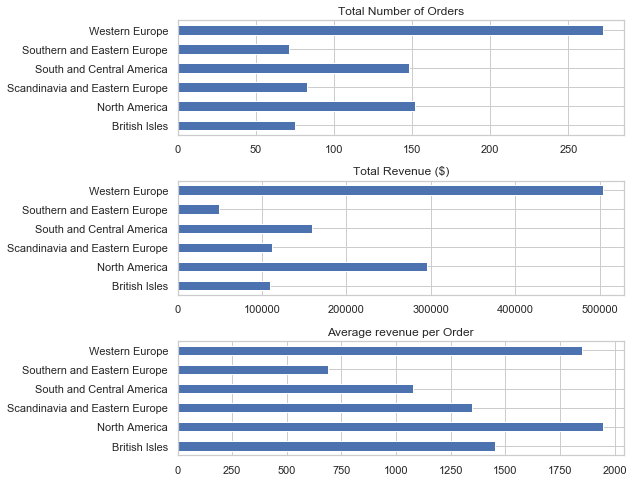

In [41]:
#Visualizing number of orders, total revenue per order and average revenue per order for each region
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,8))
customer_region.groupby(['Region'])['Region'].count().plot(kind = 'barh', ax = ax1)
customer_region.groupby(['Region'])['PriceperOrder'].sum().plot(kind = 'barh', ax = ax2)
customer_region.groupby(['Region'])['PriceperOrder'].mean().plot(kind = 'barh', ax = ax3)
ax1.set_title('Total Number of Orders')
ax1.set_ylabel('')
ax2.set_title('Total Revenue ($)')
ax2.set_ylabel('')
ax3.set_title('Average revenue per Order')
ax3.set_ylabel('')
fig.subplots_adjust(hspace = 0.4);
fig.savefig('region.png', bbox_inches = 'tight')

The graphs shows us that Western Europe is the region with the greatest number of orders and greatest total revenue. However, North America is the greatest average revenue per order (with Western Europe being a close second). Southern and Eastern Europe have the lowest number of orders, total revenue and average revenue per order. We will investigate if these differences are statisitcal significant.

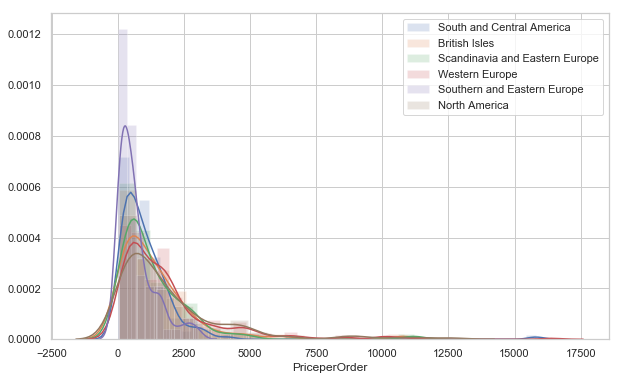

In [42]:
plt.figure(figsize=(10,6))
for region in set(customer_region.Region):
    region_group = customer_region.loc[customer_region['Region']== region]
    sns.distplot(region_group['PriceperOrder'], hist_kws=dict(alpha=0.2), label= region)
    plt.legend()
    

Looking at the distribution above, we see that it is positively skewed with heavy tails. In order to perform an ANOVA test, the data should be normally distributed. Log transforming the data will be the best way to give results that are more normally distributed.

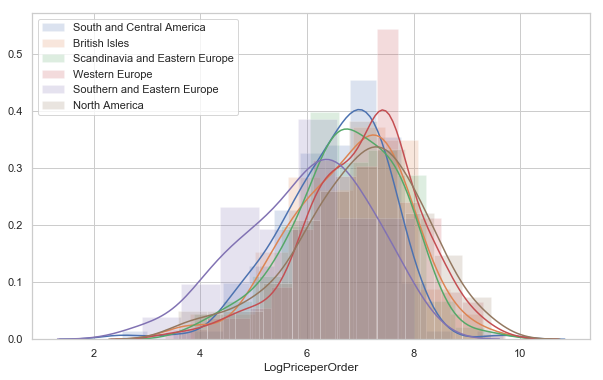

In [43]:
customer_region_log = customer_region.copy()
customer_region_log['LogPriceperOrder'] = np.log(customer_region['PriceperOrder'])
plt.figure(figsize=(10,6))
for region in set(customer_region_log.Region):
    region_group = customer_region_log.loc[customer_region_log['Region']== region]
    sns.distplot(region_group['LogPriceperOrder'], hist_kws=dict(alpha=0.2), label= region)
    plt.legend() 

The data looks more normally distributed and we can move on to the ANOVA test:

In [44]:
lm = ols('LogPriceperOrder ~ C(Region)', customer_region_log).fit()
sm.stats.anova_lm(lm, typ =2)

,sum_sq,df,F,PR(>F)
C(Region),77.999547,5.0,13.032374,3.285724e-12
Residual,951.624641,795.0,NaN,NaN


In [63]:
# Difference between the average price of orders from Southern and Eastern European customers to those from North American customers
#print("Absolute difference: ", float(round((customer_region.loc[customer_region.Region == 'North America']).mean() - (customer_region.loc[customer_region.Region == 'Southern and Eastern Europe']).mean(),2)))
#print("Proportional difference: ", float(round(1 + ((customer_region.loc[customer_region.Region == 'North America']).mean() - (customer_region.loc[customer_region.Region == 'Southern and Eastern Europe']).mean()) / ((customer_region.loc[customer_region.Region == 'Southern and Eastern Europe']).mean()),2)))

Because the p-value < 0.05, we can reject the null hypothesis and accept the alternative hypothesis. We conclude that there is a significant difference between the order revenue between the different regional customers, ie. customers from different parts of the world spend different amounts of money on their orders.

### Question 4

### Relationship between freight costs and the different shipping companies?

In order to answer this question, we need to acknowledge that are several limitations in the given dataset. Information about the weight of packages, distance of delivery, and delivery time are not avaiable to us. These results should be take as a grain of salt.

- $H_0$: The average freight cost is the same among all the shippers
- $H_a$: The average freight cost is different among the different shippers
- $alpha$ = 0.05

In [47]:
c.execute('''SELECT Id , ShipVia, Freight, ShipRegion, RequiredDate, ShippedDate, OrderDate  FROM [Order];''')
df_freight = pd.DataFrame(c.fetchall())
df_freight.columns = [column[0] for column in c.description]
df_freight.head()

,Id,ShipVia,Freight,ShipRegion,RequiredDate,ShippedDate,OrderDate
0,10248,3,32.38,Western Europe,2012-08-01,2012-07-16,2012-07-04
1,10249,1,11.61,Western Europe,2012-08-16,2012-07-10,2012-07-05
2,10250,2,65.83,South America,2012-08-05,2012-07-12,2012-07-08
3,10251,1,41.34,Western Europe,2012-08-05,2012-07-15,2012-07-08
4,10252,2,51.30,Western Europe,2012-08-06,2012-07-11,2012-07-09


In [48]:
df_freight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 7 columns):
Id              830 non-null int64
ShipVia         830 non-null int64
Freight         830 non-null float64
ShipRegion      830 non-null object
RequiredDate    830 non-null object
ShippedDate     809 non-null object
OrderDate       830 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 45.5+ KB


In [49]:
df_freight.dropna(inplace = True)
df_freight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809 entries, 0 to 821
Data columns (total 7 columns):
Id              809 non-null int64
ShipVia         809 non-null int64
Freight         809 non-null float64
ShipRegion      809 non-null object
RequiredDate    809 non-null object
ShippedDate     809 non-null object
OrderDate       809 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 50.6+ KB


In [50]:
df_freight.ShipVia.value_counts()

2    315
3    249
1    245
Name: ShipVia, dtype: int64

In [51]:
c.execute("""SELECT * FROM Shipper""")
shippers_df = pd.DataFrame(c.fetchall())
shippers_df.columns = [column[0] for column in c.description]
shippers_df.head()

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


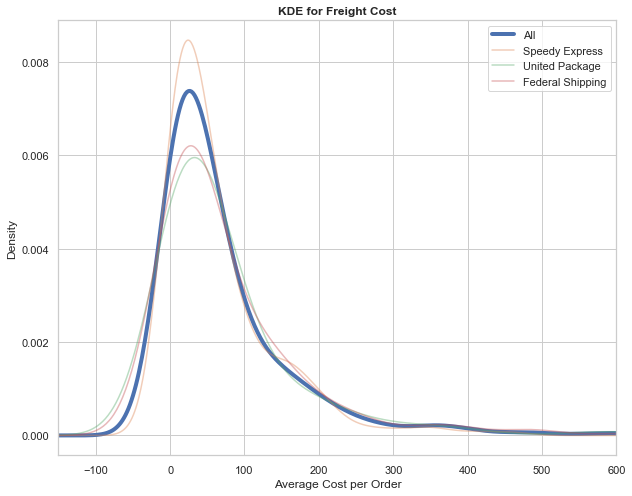

In [52]:
shippers = pd.DataFrame([])
plt.figure(figsize=(10, 8))
df_freight.Freight.plot.kde(label = 'All', linewidth = 4)
for i in [1,2,3]:
    x = df_freight[df_freight['ShipVia'] == i]
    y = df_freight[df_freight['ShipVia'] != i]
    x.Freight.plot.kde(label = shippers_df.CompanyName[i-1], alpha = .4)
    results = stats.ttest_ind(x.Freight, y.Freight, equal_var = False)
    shippers = shippers.append(pd.DataFrame({'Shipper': shippers_df.CompanyName[i-1], 'Coeffiecient': round(results[0], 3),
                                            'P-value': round(results[1], 3)}, index = [0]), ignore_index = True)
plt.title('KDE for Freight Cost', fontweight = 'bold')
plt.xlabel('Average Cost per Order')
plt.legend()
plt.xlim(-150, 600)
plt.show()

In [53]:
shippers

,Shipper,Coeffiecient,P-value
0,Speedy Express,-2.655,0.008
1,United Package,1.517,0.130
2,Federal Shipping,0.433,0.665


Based on the above, Shipper Express has a p-value < 0.05 and thus the results are statitstically significance. However this is misleading because there are several variables that are unknown to us. Lets explore the same analysis for each region that products are shipped to.

In [54]:
Regions=['Western Europe','North America','Southern Europe',
         'British Isles','Scandinavia','Victoria',
         'Northern Europe','Eastern Asia','NSW',
         'South-East Asia','South America']
for i in Regions:
    shipper_region = pd.DataFrame([])
    reg = df_freight[df_freight['ShipRegion']==i]
    count = 0
    for j in [1,2,3]:
        x = reg[reg['ShipVia']==j]
        y = reg[reg['ShipVia']!= j]
        if x.shape[0] > 1 and y.shape[0] > 1:
            count+= 1
            results = stats.ttest_ind(x.Freight, y.Freight, equal_var = False)
            shipper_region = shipper_region.append(pd.DataFrame({'Shipper': shippers_df.CompanyName[j-1],
                                                                'Coefficient': round(results[0], 3),
                                                                'P-value': round(results[1], 3)},index=[0]), ignore_index = True)
        else:
            None
    if count == 3:
        print(i)
        print(shipper_region)
        print('')

Western Europe
            Shipper  Coefficient  P-value
0    Speedy Express       -0.650    0.516
1    United Package       -0.927    0.355
2  Federal Shipping        1.488    0.140

North America
            Shipper  Coefficient  P-value
0    Speedy Express       -2.215    0.028
1    United Package        0.452    0.652
2  Federal Shipping        0.812    0.419

Southern Europe
            Shipper  Coefficient  P-value
0    Speedy Express       -1.393    0.169
1    United Package        1.590    0.124
2  Federal Shipping       -0.588    0.559

British Isles
            Shipper  Coefficient  P-value
0    Speedy Express       -0.557    0.580
1    United Package        1.327    0.192
2  Federal Shipping       -1.365    0.176

Scandinavia
            Shipper  Coefficient  P-value
0    Speedy Express       -0.771    0.451
1    United Package        1.757    0.109
2  Federal Shipping       -1.568    0.130

Northern Europe
            Shipper  Coefficient  P-value
0    Speedy Express       

We find that it is cheaper for Shipper Express to ship to North America and for United Package to ship to Northern Europe. Now we shall if there is a difference in how days it takes to ship products.

## Do customers spend more on products on  particular days of the week?

- $H_0$: Customers spend about the same amount for each day of the week
- $H_a$: Customers spend different amounts on different days of the week 
- $alpha$ = 0.05

In [55]:
c.execute("""SELECT o.OrderDate, od.Quantity FROM [Order] o 
JOIN OrderDetail od ON od.OrderId = o.Id""")
product_day = pd.DataFrame(c.fetchall())
product_day.columns = [column[0] for column in c.description]
product_day.head()

,OrderDate,Quantity
0,2012-07-04,12
1,2012-07-04,10
2,2012-07-04,5
3,2012-07-05,9
4,2012-07-05,40


In [56]:
product_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 2 columns):
OrderDate    2155 non-null object
Quantity     2155 non-null int64
dtypes: int64(1), object(1)
memory usage: 33.8+ KB


Order date needs to be converted from a full date to the day of the week.

In [57]:
product_day['OrderDate'] = pd.to_datetime(product_day.OrderDate)
product_day['DayofWeek'] = product_day['OrderDate'].dt.weekday_name
product_day['int_day_of_week'] = product_day['OrderDate'].dt.dayofweek

In [58]:
product_day.head()

,OrderDate,Quantity,DayofWeek,int_day_of_week
0,2012-07-04,12,Wednesday,2
1,2012-07-04,10,Wednesday,2
2,2012-07-04,5,Wednesday,2
3,2012-07-05,9,Thursday,3
4,2012-07-05,40,Thursday,3


In [59]:
#produce date range:
print(f"The dates range from {product_day.OrderDate.min().date()} to {product_day.OrderDate.max().date()}")

The dates range from 2012-07-04 to 2014-05-06


(734716.0, 735354.0)

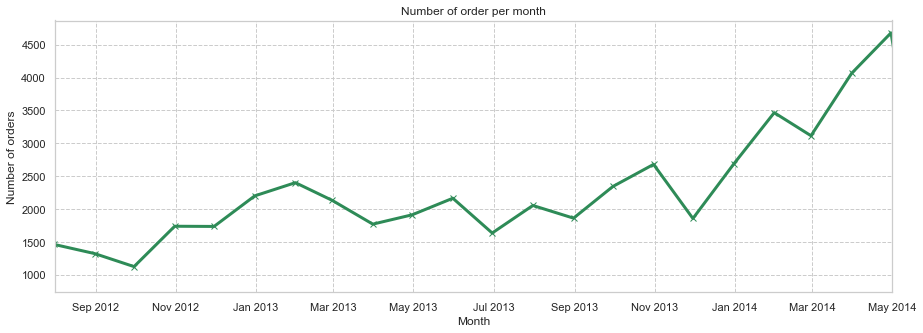

In [60]:
per_month = product_day.set_index('OrderDate').groupby(pd.Grouper(freq='M'))['Quantity'].sum()

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(per_month.index, per_month.values, marker = 'x', color ='seagreen', linewidth = 3)
ax.set_title('Number of order per month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of orders')
ax.grid(linestyle='--')
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
#ax.axis.set_major_locator(mdates.MonthLocator())
ax.set_xlim(left='2012-08-01', right ='2014-05-01')

The graph above plots the number of orders over the 2 year period and will show a general upward trend 

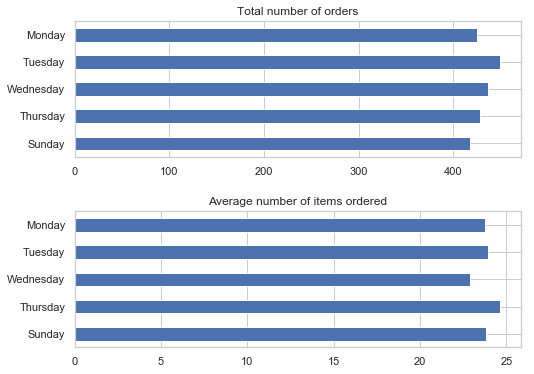

In [61]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6))
product_day.sort_values(['int_day_of_week'], ascending = False).groupby(['DayofWeek'], sort = False)['DayofWeek'].count().plot('barh', ax=ax1)
product_day.sort_values(['int_day_of_week'], ascending = False).groupby(['DayofWeek'], sort = False)['Quantity'].mean().plot('barh', ax=ax2)
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_title('Average number of items ordered')
ax2.set_ylabel('')
fig.subplots_adjust(hspace=.4)
fig.savefig('daysofweek.png', bbox_inches = 'tight')

In [62]:
#ANOVA test
lm = ols('Quantity ~C(DayofWeek)', product_day).fit()
print(lm.summary())
sm.stats.anova_lm(lm, typ =2)

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4571
Date:                Thu, 29 Aug 2019   Prob (F-statistic):              0.767
Time:                        11:31:43   Log-Likelihood:                -9404.2
No. Observations:                2155   AIC:                         1.882e+04
Df Residuals:                    2150   BIC:                         1.885e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

,sum_sq,df,F,PR(>F)
C(DayofWeek),662.192111,4.0,0.457058,0.7673
Residual,778737.444084,2150.0,NaN,NaN


Because our p-value is 0.76, we fail to reject our null hypothesis and can say there is no difference what day of the week products are ordered.

## 5. Conclusions

1. There is a statistically significant difference between number of items ordered between discounted items and non-discounted items. However there is no significant effect between the varying discount levels. Try keeping discount levels low (about 5% is optimal)
2. There is a statistical significant difference in revenue for orders with or without discounts. On average, customers spend $143 more on orders with discounts than without discounts, which is a 7% increase
3. There is a statistically significant difference in the average revenue per order from customers in different regions. By far, Western European customers spent the most and are the biggest contributors to Northwind's bottom line. If Northwind chooses to focus on bigger markets, it would need to stop marketing in Southern and Eastern Europe.
4. In terms of freight cost, Speedy Express is the least expensive shipper and should be used whenever possible.
5. Customers usually order their products at about the same rate every day of the week. May not need to staff different days with different sales representatives